# Load the data

In [48]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
# pd.options.display.max_columns
pd.set_option("display.max_colwidth",200)
pd.set_option("display.max_columns",20)
pd.set_option('float_format', '{:.3f}'.format)

# Load Usage data
with open('App_usage_trace.txt') as f:
    lines = f.readlines()#[:100000]
    df = []
    for line in lines:
        data = line.split()
        df.append(data)
usage = pd.DataFrame(df, columns=['uid','timestamp', 'loc', 'app_id','traffic'])
# output_user(usage)
usage['traffic'] = usage['traffic'].astype('float64') / 1e6 # Convert traffic to MB
usage['timestamp'] = usage['timestamp'].apply(lambda x: datetime.strptime(x, "%Y%m%d%H%M%S")) # Convert to datetime object
usage['loc'] = usage['loc'].astype('int64')

# Load App2Category data
with open('App2Category.txt') as f:
    lines = f.readlines()
    df = []
    for line in lines:
        data = line.split()
        df.append(data)
app2cat = pd.DataFrame(df, columns=['app_id','cat_id'])

# Load base station POI data
base_poi = pd.read_csv("base_poi.txt", delimiter='\t')

# Load Category dictionary
cat = pd.read_csv("Categorys.txt", delimiter='\t', header=None)
cat.columns = ['cat_id','category']
cat.set_index('cat_id', inplace=True)


print("< ---- Basic information ---- >")
print("- {} base stations. {} entries".format(base_poi.shape[0], usage.shape[0]))
print()
print("< ---- Unique users ---- >")
print("- {} unique users".format(len(usage['uid'].unique())))



< ---- Basic information ---- >
- 9851 base stations. 4171950 entries

< ---- Unique users ---- >
- 871 unique users


In [47]:
def output_user(data):
    # group data into users
    grouped_users = data.groupby('uid')
    for user, group in grouped_users:
        # iterare each user and output to seperate file
        group.to_csv('user_{}.txt'.format(user), header=False, index=False, sep=' ')

In [4]:
# Load base station POI data
base_poi = pd.read_csv("base_poi.txt", delimiter='\t')

base_poi.set_index('BaseID', inplace=True)
base_poi['total'] = base_poi.sum(axis=1)

In [5]:
# Group user count to find heavy users uid later
user_count = usage.groupby(["uid"]).size().reset_index()
user_count.columns = ['uid','count']

## Just to use some simple rules to remove users / base stations

In [6]:
def remove_records(n_user=2000, n_base=5):
    # Remove user with less than n records
    user_count_clean = user_count[user_count['count'] > n_user]
    print('='*50)
    print("We remove users with less than {} records".format(n_user))
    print("-"*50)
    print("# of base station before cleaning:", user_count.shape[0])
    print("# of users after cleaning:", user_count_clean.shape[0])
    print()
    # Store the uid that we removed
    removed_user = user_count[user_count['count'] < n_user].index
    removed_user = list(removed_user)
    print("Removed {} users and returned a list of removed uid".format(len(removed_user)))
    print()
    print('='*50)
    # Remove Base station with less than n POI
    print("We remove base station with less than {} POI".format(n_base))
    print("-"*50)

    print("# of base station before cleaning:", base_poi.shape[0])
    base_poi_clean = base_poi[base_poi['total'] > n_base]
    print("# of base station after cleaning:", base_poi_clean.shape[0])
    print()
    # Store the baseID we are removing
    removed_base = base_poi[base_poi['total'] < n_base].index
    removed_base = list(removed_base)
    print("Removed {} base and returned a list of removed baseID".format(len(removed_base)))

    # Remove the records that match either the removed user or removed baseID
    # Return the dataset

    return removed_user, removed_base


In [7]:
removed_user, removed_base = remove_records(1000, 20)

We remove users with less than 1000 records
--------------------------------------------------
# of base station before cleaning: 871
# of users after cleaning: 560

Removed 311 users and returned a list of removed uid

We remove base station with less than 20 POI
--------------------------------------------------
# of base station before cleaning: 9851
# of base station after cleaning: 5768

Removed 3947 base and returned a list of removed baseID


In [46]:
def output_user(data):
    grouped_users = data.groupby('uid')
    for user, group in grouped_users:
        group.to_csv('user_{}.txt'.format(user), header=False, index=False, sep=' ')

    0.002
135613  175 2016-04-20 08:48:20  3045   1420    0.010
135614  175 2016-04-20 08:50:07  3045   1420    0.007
135615  175 2016-04-20 08:50:08  3045   1420    0.078
135616  175 2016-04-20 08:50:23  3045   1420    0.002
...     ...                 ...   ...    ...      ...
136327  175 2016-04-26 18:06:08  3045     55    0.003
136328  175 2016-04-26 18:06:09  3045     18    0.000
136329  175 2016-04-26 18:06:09  3045     55    0.000
136330  175 2016-04-26 18:06:10  3045     18    0.085
136331  175 2016-04-26 18:06:11  3045     55    0.001

[720 rows x 5 columns]
176
        uid           timestamp   loc app_id  traffic
136332  176 2016-04-20 14:49:28  6203    534    0.001
136333  176 2016-04-20 17:06:53  5308     65    0.002
136334  176 2016-04-20 17:12:10  6205    534    0.002
136335  176 2016-04-20 17:52:03  5886    534    0.001
136336  176 2016-04-20 18:23:50  4990   1420    0.001
...     ...                 ...   ...    ...      ...
136589  176 2016-04-26 17:59:20  5307     65

KeyboardInterrupt: 

# Handle the oscillatoin problem

## Hybrid Approach

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Function to align the Origin and Destination (O/D)
def sort_movement_tuples(jump):
    return sorted(list(jump))

# Define a function that can output the frequency pair of a user's mobility pattern
def show_frequent_pair(uid=888, threshold=5, jump_occurence=10):

    user_uid = usage[usage['uid'] == str(uid)]

    # Set the thresold of time gap allowed between movement
    delta_threshold = timedelta(seconds=threshold)

    # Create the columns of the next time and lcoation
    user_uid['next_loc'] = user_uid['loc'].shift(-1).fillna(0).astype('int')
    user_uid['next_timestamp'] = user_uid['timestamp'].shift(-1)

    # Keep only movements
    user_uid = user_uid[user_uid['loc'] != user_uid['next_loc']]

    # Get the time gaps between movements
    user_uid['time_delta'] = user_uid['next_timestamp'] - user_uid['timestamp']

    # Get teleports and count the teleports
    # Should be able to identify the return trips
    teleports = user_uid[user_uid['time_delta'] < delta_threshold]
    teleports['tele'] = list(zip(teleports['loc'], teleports['next_loc']))
    # print(teleports['tele'].value_counts())

    # Group and count the same jump
    tele_counts = teleports['tele'].value_counts().reset_index()
    tele_counts.columns = ['jump', 'count']

    # Align the O/D of the jump to identify the pairs
    tele_counts['jump'] = tele_counts['jump'].apply(lambda i: sort_movement_tuples(i))

    # Get the jumps that has a reasonable number of occurence
    tele_counts = tele_counts[tele_counts['count'] > jump_occurence]
    tele_counts['jump'] = tuple(tele_counts['jump'])

    # print the record for reference
    frequent_pairs = tele_counts.groupby(['jump']).sum()
    # print(frequent_pairs)

    return frequent_pairs


In [10]:
# Show the frequent pairs of user 13, gap less than 3 seconds, and occurence higher than 5 times (both directions count)
freq_pair = show_frequent_pair(13,3,5)
# freq_pair.head(20)

### Algorithm to approximate the baseID clusters

In [11]:
# experiment = ['888','772','837']
experiment = [772]

base_cluster = []
skipped_jump = []

for user in experiment:
    freq_pair = show_frequent_pair(user,1,5)

    # Loop over the unique jump pattern
    for i in freq_pair.index:

        # Get the first and second baseID
        loc1 = i[0]
        loc2 = i[1]
        
        # Start storing clusters
        if len(base_cluster) == 0:
            base_cluster.append(list(i)) # Add the first jump to the cluster

        # Start expanding or creating new clusters
        # Loop through each cluster
        for pos in range(len(base_cluster)):

            # if loc1 is in the cluster, we assume loc2 is a base station near the cluster. Vice versa
            # Then we add both baseID to the cluster. Either one of them is already in there anway
            if loc1 == base_cluster[pos][0]:
                
                # print(list(i))
                # We add the new baseID to the existing cluster
                base_cluster[pos] += list(i)
                # base_cluster[pos]  = set(a)
                new_cluster = 0 # Saying we do not need to create a new cluster
                break

            # If one of the baseID is linked to the cluster, we flag up to create a new cluster
            else:
                new_cluster = 1
                
        # Save the jump later for the reason below
        if new_cluster == 1:
            base_cluster.append(list(i))
            new_cluster = 0

# Previous method
# Issue happens a the end of the loop. A jump with two new baseID created a new cluster. Then the next jump has one baseID connected to previous cluster. In that case, the new cluster created in the previous jump should be included in the bigger cluster. Therefore, we skipped the jumps and process it later in the cell below


# a = [sorted(set(list(x))) for x in base_cluster]
print("We approximated {} clusters.".format(len(base_cluster)))

We approximated 417 clusters.


In [12]:
base_mapper = {}
for i in base_cluster:
    base_mapper[i[0]] = sorted(list(set(i[1:])))

# pprint(base_mapper)

In [13]:
a = [set(list(x)) for x in base_cluster]

In [14]:
# # We count the occurence of baseID from all cluster
# # I assume the baseID will not repeat but it is not
# count_occurence = {}
# for combo in a:
#     for place in combo:
#         if place in count_occurence.keys():
#             count_occurence[place] += 1
#         else:
#             count_occurence[place] = 1

# # Show results in a dictionary
# from collections import Counter
# results = dict(Counter(list(count_occurence.values())))
# print(results)
# print()
# print("Some baseID appear in more than one clusters")
# print("Have to investigate why")

In [15]:
# [[k, v] for k, v in sorted(count_occurence.items(), key=lambda item: item[1], reverse=True)][:10]

## Speed Approach

In [16]:
def reduce_noise(uid=888, threshold=300, show_graph=False):

    user_uid = usage[usage['uid'] == str(uid)]
    user_uid.reset_index(inplace=True, drop=True)
    user_uid.drop(['app_id', 'traffic'], axis=1, inplace=True)

    # Set the thresold of time gap allowed between movement
    delta_threshold = timedelta(seconds=threshold)

    # Create the columns of the previous time and location
    user_uid['prev_loc'] = user_uid['loc'].shift(1).fillna(9999).astype('int')
    user_uid['prev_timestamp'] = user_uid['timestamp'].shift(1)
    user_uid['original'] = user_uid['loc']
    # Get the time gaps between movements
    user_uid['time_delta'] =  user_uid['timestamp'] - user_uid['prev_timestamp']


    origin_user_uid = user_uid.copy()

    before = user_uid['loc'].value_counts().shape[0]

    for i in user_uid[user_uid['time_delta'] < timedelta(seconds=threshold)].index:
        user_uid.iloc[i,2] = user_uid.iloc[i-1,2]

    after = user_uid['loc'].value_counts().shape[0]


    if show_graph == True:

        print("="*50)
        print("From {} to {} unique_base...".format(before, after))
        print("="*50)
        print()
        
        clean_user_uid = user_uid.copy()

        fig, axs = plt.subplots(2, figsize=(15,3))
        fig.suptitle('Uid: {}'.format(uid))

        # plt.figure(figsize=(15,3))
        axs[0].scatter(origin_user_uid['timestamp'],origin_user_uid['loc'], alpha=0.5)
        axs[1].scatter(clean_user_uid['timestamp'],clean_user_uid['loc'], alpha=0.5)
        plt.show()
    
    return int(before - after)

From 73 to 25 unique_base...



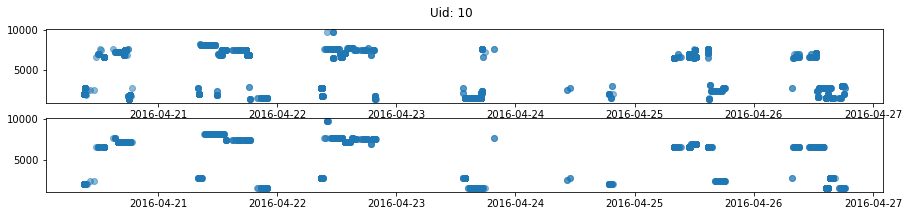

From 54 to 20 unique_base...



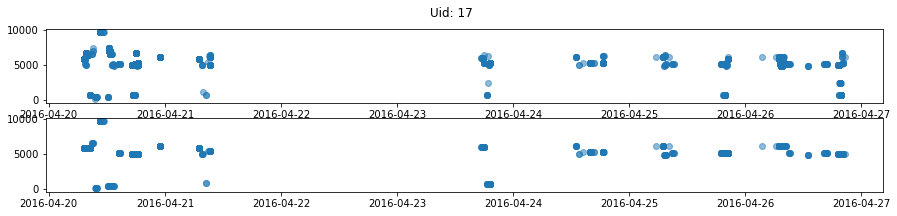

From 35 to 20 unique_base...



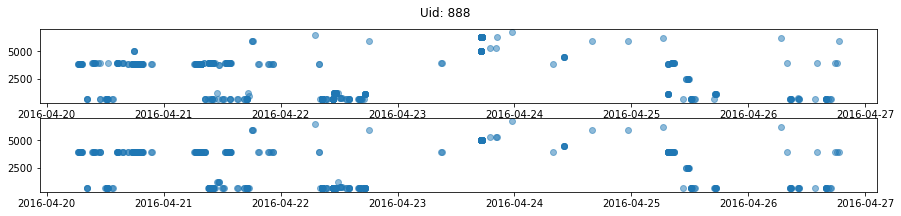

Done


In [17]:
sample_group = [10, 17, 888]
threshold = 1200 # seconds

reduce_result = []
for u in sample_group:
    reduce_result.append(reduce_noise(u, threshold, True)) # 
print("Done")

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [19]:
usage.head(10)

,uid,timestamp,loc,app_id,traffic
0,0,2016-04-20 08:13:19,8194,361,0.002
1,0,2016-04-20 08:13:20,8194,361,0.002
2,0,2016-04-20 08:13:22,8194,361,0.004
3,0,2016-04-20 08:13:30,8194,361,0.001
4,0,2016-04-20 08:13:31,8194,361,0.002
5,0,2016-04-20 08:16:44,8194,361,0.002
6,0,2016-04-20 08:16:49,8194,31,0.002
7,0,2016-04-20 08:16:49,8194,360,0.002
8,0,2016-04-20 08:16:49,8194,612,0.002
9,0,2016-04-20 08:16:50,8194,31,0.003
